**LABORATORIO 7**

* Dataset:https://drive.google.com/drive/folders/1uqRTLV8lWfsZ7u1GXe3z90gajNlOry-t?usp=sharing
* repositorio github:https://github.com/R1mber/sis421/tree/master/Laboratorios
* Transformer Utilizando el dataset de Basura
* 

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 8.5 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
     |████████████████████████████████| 418 kB 59.2 MB/s 
     |████████████████████████████████| 140 kB 60.2 MB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
     |████████████████████████████████| 271 kB 68.2 MB/s 
     |████████████████████████████████| 144 kB 58.0 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image, ImageOps

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!cp -av "/content/drive/MyDrive/Dataset_basura/" "/content/img"

Se han truncado las últimas 5000 líneas del flujo de salida.
'/content/drive/MyDrive/Dataset_basura/papel/papel (136).png' -> '/content/img/papel/papel (136).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (138).png' -> '/content/img/papel/papel (138).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (139).png' -> '/content/img/papel/papel (139).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (140).png' -> '/content/img/papel/papel (140).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (142).png' -> '/content/img/papel/papel (142).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (141).png' -> '/content/img/papel/papel (141).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (146).png' -> '/content/img/papel/papel (146).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (143).png' -> '/content/img/papel/papel (143).png'
'/content/drive/MyDrive/Dataset_basura/papel/papel (149).png' -> '/content/img/papel/papel (149).png'
'/content/drive/MyDri

In [6]:
import os
path = '/content/img/'
directorios = os.listdir(path)
directorios

['BolsasPlasticas',
 'metales',
 'papel',
 'BotellasVidrio',
 'cartones',
 'Envaces_Vidrio',
 'EnvasesPlasticos',
 'botellas_de_plastico',
 'Plastoformos']

In [7]:
labels_def = {
    'BolsasPlasticas':0,
    'metales':1,
    'papel':2,
    'BotellasVidrio':3,
    'cartones':4,
    'Envaces_Vidrio':5,
    'EnvasesPlasticos':6,
    'botellas_de_plastico':7,
    'Plastoformos':8,
}

In [8]:
def loadImages(path, directorio):
    labels_ = []
    images_ = []
    for d in directorio:
        imagenes = os.listdir(path + d)
        for i in imagenes:
            imgPath2 = path + d + '/' + i
            img1 = Image.open(imgPath2)
            new_img = img1.resize((56,56)).convert('RGB')
            gray_image = ImageOps.grayscale(new_img)
            images_.append(np.array(gray_image)/255)
            labels_.append(labels_def[d])

    return images_, labels_

def getText(label):
    for key in labels_def:
      if labels_def[key] == label:
        return key

In [9]:
imgs , labels = loadImages(path,directorios)

In [10]:
imgs = np.array(imgs)
labels = np.array(labels)

In [11]:
imgs.shape, labels.shape

((11183, 56, 56), (11183,))

In [12]:
dims = imgs.shape[1] * imgs.shape[2]
imgs = imgs.reshape(imgs.shape[0], dims)
imgs.shape

(11183, 3136)

In [13]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.07, stratify=labels)

len(train_imgs), len(test_imgs)

(10400, 783)

In [14]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()


In [15]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        # mnist = fetch_openml('mnist_784', version=1)
        #X, y = mnist["data"], mnist["target"]
        X, y = imgs, labels
        X_train, X_test = train_imgs, test_imgs
        y_train, y_test = train_labels, test_labels
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [16]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 3136]), torch.Size([64]))

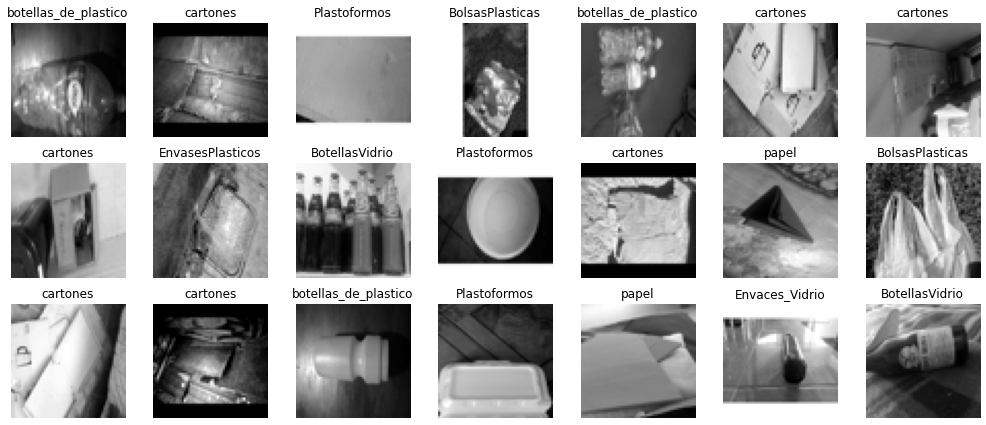

In [17]:
r, c = 3, 7
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(56,56), cmap="gray")
        ax.set_title(getText(label.item()))
plt.tight_layout()
plt.show()

In [18]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(3136, 3136),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(3136, 9)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0002)
        return optimizer

In [19]:
mlp = MLP()
outuput = mlp(torch.randn(64, 3136))
outuput.shape

torch.Size([64, 9])

In [20]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=10, gpus=1, logger=None)
trainer.fit(mlp, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 9.9 M 
------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.463    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

**Entrenamiento con un MLP**
Los resultados de: 83 % de precisión

*  



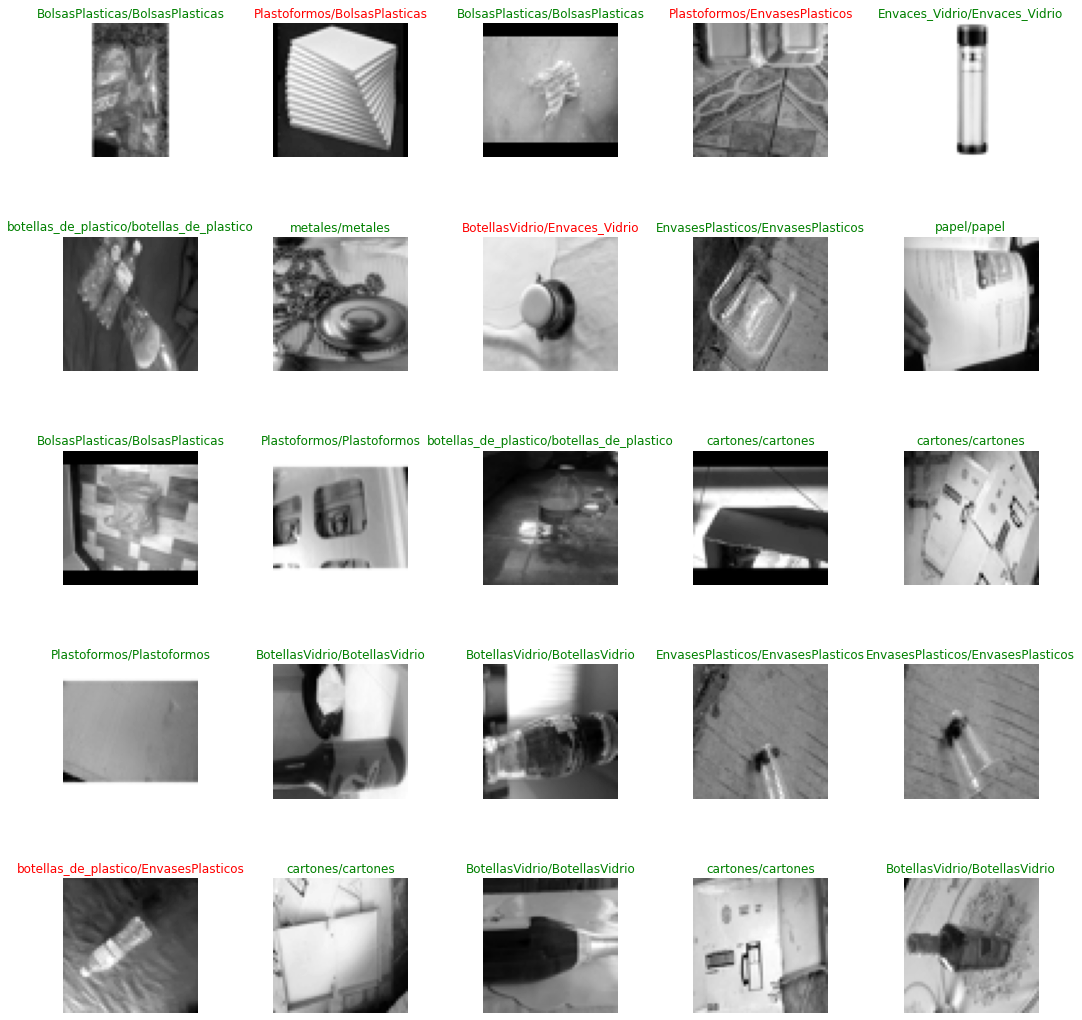

In [21]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 5, 5
fig = plt.figure(figsize=(3*c, 3*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(56,56), cmap="gray")
        ax.set_title(f'{getText(label.item())}/{getText(preds[ix].item())}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

In [22]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X 
    self.y = y 
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(56, 56) # 56 x 56 
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 8 x 8 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 64 x 49
    return patches, torch.tensor(self.y[ix]).long()

In [23]:
attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 64, 49]), torch.Size([64]))

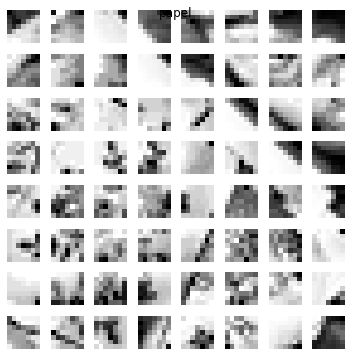

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i*8 + j + 1)
        ax.imshow(imgs[6,i*8 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{ getText(labels[6])}')
plt.tight_layout()
plt.show()

In [25]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class MultiHeadAttention(torch.nn.Module):
    #n_enbd = 7 x 7
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size() # B= batch, L = 64 recortes, F = 49 pixeles en cada corte
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)
    
class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = self.ln1(x + self.attn(x))
        x = self.ln2(x + self.mlp(x))
        return x
    
class Model(MLP):

    def __init__(self, n_input=7*7, n_embd=7*7, seq_len=8*8, n_heads=8*8, n_layers=1):
        super().__init__()
        self.mlp = None
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)])
        #retornamos todo los datos a la salida :3136 , 9 clases
        self.fc = torch.nn.Linear(n_embd*seq_len, 9)

    def forward(self, x):
        # embedding
        e = self.inp_emb(x) + self.pos_emb
        # transformer blocks
        x = self.tranformer(e)
        # classifier
        y = self.fc(x.view(x.size(0), -1))
        return y

In [26]:
model = Model(n_layers=3)
trainer = pl.Trainer(max_epochs=5, gpus=1, logger=None)
trainer.fit(model, attn_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | inp_emb    | Linear     | 2.5 K 
1 | tranformer | Sequential | 1.9 M 
2 | fc         | Linear     | 28.2 K
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.860     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

**Entrenamiento con un TRANSFORMER**

* Los resultados de: 94 % de precisión





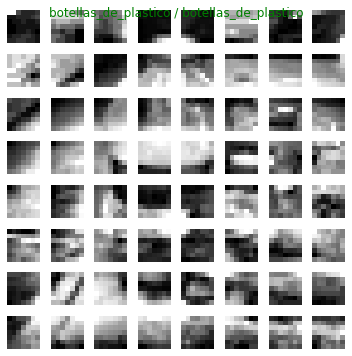

In [27]:
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0,attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i*8 + j + 1)
        ax.imshow(attn_imgs[ix,i*8 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{ getText(attn_labels[ix])} / {getText(preds[ix].item())}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()